# Crowdflower Search Result Relevance

* 설명
  * 검색 결과의 관련성을 측정하는 데 사용할 수있는 오픈 소스 모델을 만드는 것
  * 전자 상거래 사이트의 검색어 및 결과 제품, 제품 설명을 통해 검색 알고리즘의 정확성을 평가

* 평가
  * 두 등급 간의 일치도를 측정하는 quadratic weighted kappa 기준으로 채점
  * 인간의 평가 점수와 예측 평가 점수의 일치도 측정
  * 0 (평가자 간의 임의 합의)에서 1 (평가자 간의 완전한 합의)

* ### Data 설명

* train.csv - training data set
  - id : 제품 ID
  - query : 검색어 사용
  - product title : 제품 이름
  - product_description : HTML 형식 지정 태그와 함께 전체 제품 설명
  - median_relevance : 3 명의 평가자에 의한 중앙 관련성 점수. 1 - 4 사이의 정수
  - relevance_variance : 평가자가 준 관련성 점수의 편차. 

* test.csv - test data set
  - id : 제품 ID
  - query : 검색어 사용
  - product title : 제품 이름
  - product_description : HTML 형식 지정 태그와 함께 전체 제품 설명

* ampleSubmission.csv - sample submission correct format
  - id : 제품 ID
  - prediction : 예측 값

## Training Goal

* 검색어와 상품 설명 사이의 관계를 확인하기 위해서 qeury 와 description(title + description) 을 따로 embedding (Question / Result)
  - TF-IDF embedding 시 toarray를 할 경우 memory를 많이 차지하기 때문에 transform 만으로 sparse matrix 생성

* 각각 embedding 후 concate 등을 통해서 matrix 병합

* target data 가 1~4 정수의 평가 점수로 neumeric 하기 때문에 xgboot 등을 통해서 regression 적용

## 1. Preprocessing
  1. Train data 와 Test data 를 합쳐 corpus 제작 :**sentence**
  2. 3개의 product 정보를 하나로 통합 : **sentence**
  3. 대문자 Text data 를 소문자로 변환 : **sentence**
  4. stopword - 2글자 이상의 알파벳, ennglish, html 용어 : **word list**
  5. stemming : **word list**
  6. word embedding 을 위해 각 product 의 word list 를 sentence 로 변환 :**sentence**
  7. TF-IDF : **matrix**

## 2. Modeling
  1. TruncatedSVD
  2. Modeling

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score

import joblib
from joblib import dump, load

pd.options.display.max_columns = 400
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 600
pd.options.display.precision = 10

## Data load / Variables define

* train data / test data / submission data load

In [2]:
df_train = pd.read_excel("./__data/excel/train.xlsx").fillna("")
df_test = pd.read_excel("./__data/excel/test.xlsx").fillna("")
test_sub = pd.read_excel("./__data/excel/sampleSubmission.xlsx")

In [3]:
df_train.tail(3)

,id,query,product_title,product_description,median_relevance,relevance_variance
10154,32663,playstation vita system,MLB 15: The Show (PlayStation Vita),"An essential part of every fan?셲 season and The Show?셲 10th anniversary edition, MLB 15 The Show is full of new features that deliver the most accurate sports simulation possible. \n\nFor the first time, partnerships with real-world equipment brands will bring MLB-accurate bats, gloves, shoes, and batting gloves to the game. Customize your Road to The Show player in the best gear from the sport?셲 best brands. \n\nIt?셲 not just the gear that?셲 more authentic this year. Players and teams also have more unique personalities and styles plus a wide array of emotional reactions to all the heartb...",2,1.247
10155,32666,flower bulbs,Junkyard Findings Vintage Trinkets-Small Typo Bulbs 8/Pkg,PRIMA FLOWERS-Junkyard Findings Vintage Trinkets: Typo Bulbs. These trinkets have a vintage style that will look great when incorporated into various paper crafting; mixed media; or home accent projects. Each one looks like half of a light bulb and features a different sentiment printed on the surface. Overall measurements are 1-1/4x1/2x1/4 inch. This package contains eight total trinkets. Imported,1,0.471
10156,32668,polar heart rate monitor,Polar F6 Black Coal Heart Rate Monitor Mens Pink Tone,,4,0.000


* ### html 제거

In [4]:
%%time
for num in range(len(df_train['product_description'])):
    if '<ul>' in df_train['product_description'][num]:
        df_train['product_description'][num] = []        

C:\Users\tjdal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 1.31 s


In [5]:
y = df_train['median_relevance']

In [6]:
y.tail(3)

10154    2
10155    1
10156    4
Name: median_relevance, dtype: int64

In [7]:
y.unique()

array([1, 4, 2, 3], dtype=int64)

In [8]:
def count_bar_plot(data):
    data_count = data.value_counts()
    data_count.plot(kind='bar')
    plt.ylabel('Data count')
    fig = plt.gcf()
    fig.set_size_inches(12, 5)
    plt.show()

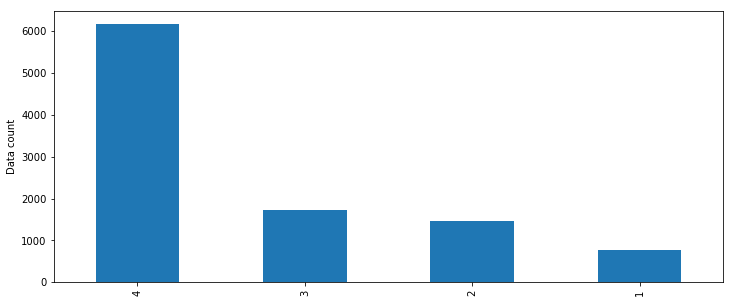

In [9]:
count_bar_plot(y)

In [393]:
joblib.dump(y, 'y.pkl')

['y.pkl']

* ### Train data / Test data 를 사용하여 corpus 제작

In [10]:
df_corpus = pd.concat([df_train, df_test], axis=0)

In [11]:
df_corpus = df_corpus.drop('median_relevance', axis = 1)
df_corpus = df_corpus.drop('relevance_variance', axis = 1)

In [12]:
pd.DataFrame(df_corpus.isnull().sum().sort_values(ascending=False))

,0
query,0
product_title,0
product_description,0
id,0


In [13]:
len((df_corpus['id']))

32670

In [14]:
df_corpus.tail(3)

,id,product_description,product_title,query
22510,32669,The Grappling Gloves are built to serve and protect. One of the best things a training fighter can do is to make sure that they don?셳 get injured while training. One of the worst things a fighter can do is to sustain an injury in the gym,Lion Martial Arts Large Red Grappling Glove Pair,gym gloves
22511,32670,"The team behind Disney's Wreck-It Ralph, the tale of a video game villain who wants to go good, committed to authenticity at every level of the movie, from including Q-Bert and and Clyde (aka the orange ghost from Pac-Man) as minor characters to making sure the film's music conveyed the golden age of arcade games and the feel of the games that followed. Wreck-It-Ralph shows that composer Henry Jackman and the other artists featured here did an impressive job of capturing that spirit without getting geeky enough to alienate anyone not steeped in gamer culture. That said, this soundtrack rel...",Wreck-It Ralph (Original Score),wreck it ralph
22512,32671,"Hair accessories that really hold! Goody Slide Proof accessories are infused with Slide-Proof technology to provide a secure hold without sacrificng style. Be confident that your accessories will not roll, slide, or fall out of your hair,no matter what! Keep your hairstyle in place with Goody Slide-Proof headwraps.","Goody Slide proof Claw Clip, Large (Pack of 2)",hair accessories


# Preprocessing

In [15]:
df_train['product_description'][3]

'Like a silent and sturdy tree, the Southern Enterprises Bird and Branch Coat Rack is an eye-catching addition to your home d챕cor. This tree themed coat rack features strong branches with pinecone accents and a small bird perched at the top to give it a whimsical and welcoming appearance while still making it sturdy enough to hold your coats, hats, umbrellas and more. Whether it serves as a coat rack, a hat rack or a combination of the two, it?셪l be a great space saver that gets appreciated for its graceful appearance.\nNumber of Hooks: 10\nFrame Material: Metal\nHardware Material: Metal\nDimensions: 69.5 " H x 13.25 " W x 13.25 " D\nWeight: 12.0 Lb.\nAssembly Details: assembly required'

* ### Question / Result 로 분리

In [27]:
# question 변수 생성

train_q = list(df_train['query'])
test_q = list(df_test['query'])

In [28]:
# result 변수 생성

train_r =list(df_train['product_title'])
test_r = list(df_test['product_title'])

In [18]:
%%time
corpusdata = list(df_corpus.apply(lambda x:'%s %s %s' % (x['query'], x['product_title'], x['product_description']), axis=1))

Wall time: 1.69 s


In [404]:
joblib.dump(corpusdata, 'corpusdata.pkl')

['corpusdata.pkl']

* #### product 정보의 최소 길이와 최대 길이 확인

In [19]:
def length_check(data):
    length = []
    for num in range(len(data)):
        length.append(len(data[num]))
    
    print('Max length : ', max(length))
    print('Min length : ', min(length))

In [29]:
length_check(train_q)

Max length :  33
Min length :  2


In [30]:
length_check(train_r)

Max length :  250
Min length :  5


In [31]:
length_check(test_q)

Max length :  33
Min length :  0


In [51]:
length_check(test_r)

Max length :  266
Min length :  0


In [44]:
for num in range(len(test_r)):
    if type(test_r[num]) != str:
        print('index :', num, ',', 'value :', test_r[num])

index : 13493 , value : 21.5
index : 14627 , value : 28
index : 16065 , value : 60
index : 16987 , value : 7.75
index : 17460 , value : 12.5
index : 19751 , value : 41.5


In [53]:
for num in range(len(test_r)):
    if type(test_r[num]) != str:
        test_r[num] = str(test_r[num])

In [54]:
length_check(test_r)

Max length :  266
Min length :  0


In [55]:
test_q[13493]

'led christmas lights'

In [56]:
print(len(corpusdata))

32670


* ### 모든 Text data 를 소문자로 변환

In [57]:
def lower_convert(data):
    for num in range(len(data)):
        data[num] = data[num].lower()

In [58]:
lower_convert(train_q)
lower_convert(train_r)
lower_convert(test_q)
lower_convert(test_r)
lower_convert(corpusdata)

In [59]:
corpusdata[:5]

['bridal shower decorations accent pillow with heart design - red/black red satin accent pillow embroidered with a heart in black thread. 8" x 8".',
 'led christmas lights set of 10 battery operated multi led train christmas lights - clear wire set of 10 battery operated train christmas lights item #x124210 features: color: multi-color bulbs with matching train light covers / clear wire multi-color consists of red, green, blue and yellow bulbs number of bulbs on string: 10 bulb size: micro led spacing between bulbs: 6 inches lighted length: 4.5 feet total length: 5.5 feet 12 inch lead cord additional product features: led lights use 90% less energy cool to the touch if one bulb burns out, the rest will stay lit lights are equipped with lamp lock feature, which makes them replaceable, interchangeable and keeps them from falling out requires 3 "aa" batteries (not included) convenient on/off/timer switch located on battery pack timer function on battery pack allows for 6 hours on and 18 h

In [60]:
length_check(corpusdata)

Max length :  25931
Min length :  2


* ### 2글자 이상의 알파벳만 존재하도록 Stopwords 생성 및 적용

In [61]:
import re

In [62]:
def alphabet_stopwords(data):
    for num in range(len(data)):
        data[num] = re.findall(r'[a-zA-Z]+', data[num])
        
    for num in range(len(data)):
        data[num] = (" ").join(data[num])
    
    for num in range(len(data)):
        data[num] = re.findall(r'\w\w+', data[num])

In [63]:
%%time
alphabet_stopwords(train_q)
alphabet_stopwords(train_r)
alphabet_stopwords(test_q)
alphabet_stopwords(test_r)
alphabet_stopwords(corpusdata)

Wall time: 3.43 s


* ### Stopwords (english)

In [64]:
from nltk.corpus import stopwords

In [65]:
def eng_stopwords(data):
    data_copy = data.copy()
    for num in range(len(data_copy)):
        data_copy[num] = []
    
    stop = stopwords.words('english')
    
    for num in range(len(data)):
        for i in range(len(data[num])):
            if data[num][i] not in stop:
                data_copy[num].append(data[num][i])
                
    return data_copy

In [66]:
%%time
train_q = eng_stopwords(train_q)
train_r = eng_stopwords(train_r)
test_q = eng_stopwords(test_q)
test_r = eng_stopwords(test_r)
corpus_data = eng_stopwords(corpusdata)

Wall time: 10.1 s


In [67]:
corpus_data[:5]

[['bridal',
  'shower',
  'decorations',
  'accent',
  'pillow',
  'heart',
  'design',
  'red',
  'black',
  'red',
  'satin',
  'accent',
  'pillow',
  'embroidered',
  'heart',
  'black',
  'thread'],
 ['led',
  'christmas',
  'lights',
  'set',
  'battery',
  'operated',
  'multi',
  'led',
  'train',
  'christmas',
  'lights',
  'clear',
  'wire',
  'set',
  'battery',
  'operated',
  'train',
  'christmas',
  'lights',
  'item',
  'features',
  'color',
  'multi',
  'color',
  'bulbs',
  'matching',
  'train',
  'light',
  'covers',
  'clear',
  'wire',
  'multi',
  'color',
  'consists',
  'red',
  'green',
  'blue',
  'yellow',
  'bulbs',
  'number',
  'bulbs',
  'string',
  'bulb',
  'size',
  'micro',
  'led',
  'spacing',
  'bulbs',
  'inches',
  'lighted',
  'length',
  'feet',
  'total',
  'length',
  'feet',
  'inch',
  'lead',
  'cord',
  'additional',
  'product',
  'features',
  'led',
  'lights',
  'use',
  'less',
  'energy',
  'cool',
  'touch',
  'one',
  'bulb',
 

* ### Stopwords (html 용어)

In [68]:
def html_stopwords(data):
    data_copy = data.copy()
    for num in range(len(data_copy)):
        data_copy[num] = []
    
    html_words = ['ul', 'li', 'td', 'tr','br', 'table', 'strong', 'color', 'size', 'font', 'px', 'text', 'link', 'item']

    for num in range(len(data)):
        for i in range(len(data[num])):
            if data[num][i] not in html_words:
                data_copy[num].append(data[num][i])
                
    return data_copy

In [69]:
%%time
train_q = html_stopwords(train_q)
train_r = html_stopwords(train_r)
test_q = html_stopwords(test_q)
test_r = html_stopwords(test_r)
corpus_data = html_stopwords(corpus_data)

Wall time: 1.93 s


## Stemming

In [70]:
from nltk.stem import PorterStemmer

In [71]:
# 타 참가자의 코드 참고

def stemPorter(text):
            porter = PorterStemmer()
            stem_data = []
            for num in text:
                final_stem = []
                for word in num:
                    final_stem.append(porter.stem(word))
                stem_data.append(final_stem)
            return stem_data

In [72]:
%%time
train_q = stemPorter(train_q)
train_r = stemPorter(train_r)

Wall time: 4.16 s


In [73]:
%%time
test_q = stemPorter(test_q)
test_t = stemPorter(test_r)

Wall time: 7.59 s


In [74]:
%%time
corpus_data = stemPorter(corpus_data)

Wall time: 1min 17s


* ### 각 Data 에 가장 많이 분포되어 있는 단어 확인

In [75]:
def words_count(data):
    words = []
    for i in range(len(data)):
        for j in range(len(data[i])):
            words.append(data[i][j])
            
    words_data = pd.DataFrame(words, columns=['words'])
    
    words_counts = words_data['words'].value_counts()
    words_counts[words_counts > sorted(words_counts)[-11]].plot(kind='bar')
    print(words_counts.keys()[:11])
    
    plt.ylabel('Data count')
    fig = plt.gcf()
    fig.set_size_inches(12, 7)
    plt.show()    

Index(['dress', 'coffe', 'maker', 'shoe', 'case', 'women', 'shirt', 'memori',
       'bike', 'pillow', 'candl'],
      dtype='object')


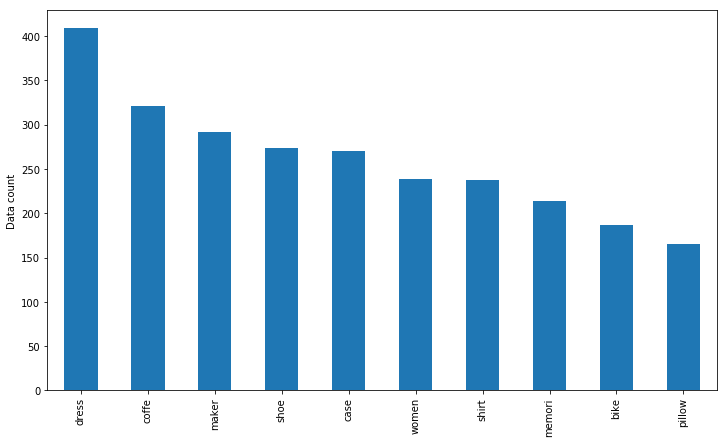

In [76]:
words_count(train_q)

Index(['black', 'women', 'men', 'set', 'white', 'dress', 'case', 'new',
       'coffe', 'oz', 'pack'],
      dtype='object')


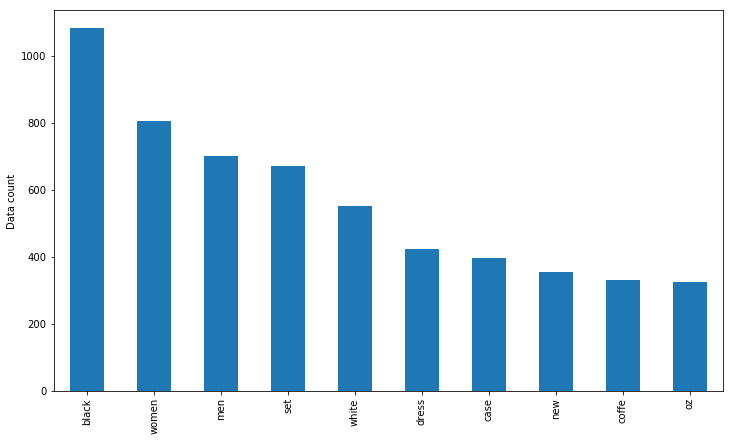

In [77]:
words_count(train_r)

Index(['dress', 'coffe', 'maker', 'shoe', 'case', 'women', 'shirt', 'bike',
       'candl', 'memori', 'wireless'],
      dtype='object')


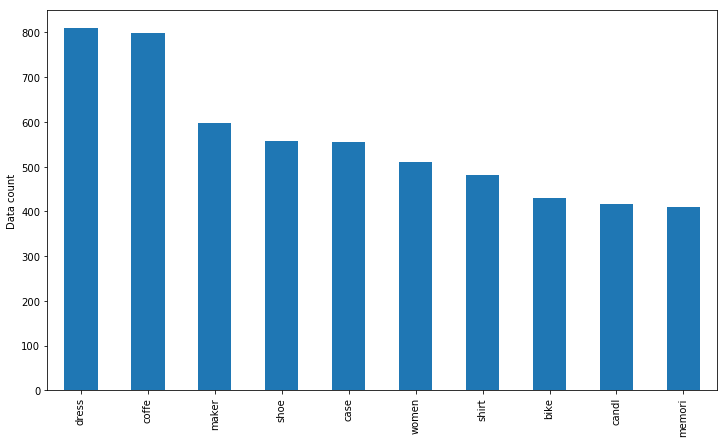

In [79]:
words_count(test_q)

Index(['black', 'women', 'set', 'white', 'men', 'new', 'case', 'coffee',
       'dress', 'pack', 'blue'],
      dtype='object')


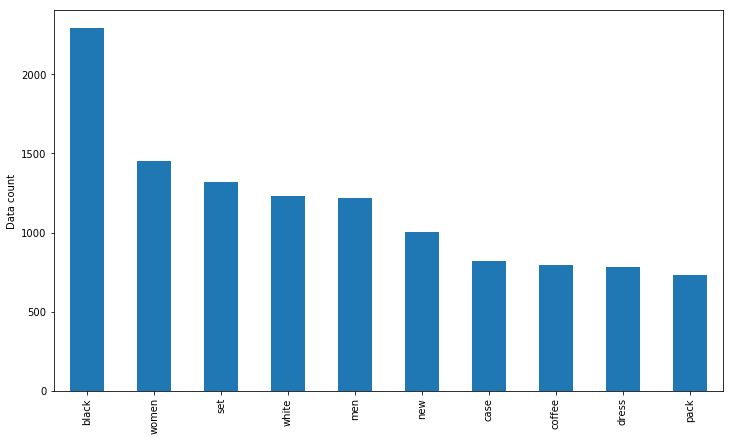

In [80]:
words_count(test_r)

Index(['featur', 'nbsp', 'design', 'new', 'set', 'use', 'includ', 'inch',
       'black', 'comfort', 'style'],
      dtype='object')


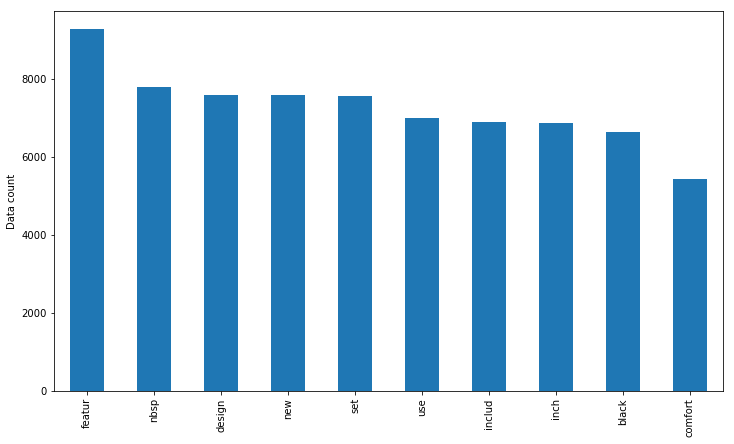

In [81]:
words_count(corpus_data)

## Data type conversion for word embadding (word list to sentence)

In [86]:
def data_join(list_data):
    for num in range(len(list_data)):
        list_data[num] = (" ").join(list_data[num])

In [87]:
data_join(train_q)
data_join(train_r)
data_join(test_q)
data_join(test_r)
data_join(corpus_data)

In [88]:
print(len(train_q))
print(len(train_r))
print(len(test_q))
print(len(test_r))
print(len(corpus_data))

10157
10157
22513
22513
32670


In [124]:
corpus_data[:5]

['bridal shower decor accent pillow heart design red black red satin accent pillow embroid heart black thread',
 'led christma light set batteri oper multi led train christma light clear wire set batteri oper train christma light featur multi bulb match train light cover clear wire multi consist red green blue yellow bulb number bulb string bulb micro led space bulb inch light length feet total length feet inch lead cord addit product featur led light use less energi cool touch one bulb burn rest stay lit light equip lamp lock featur make replac interchang keep fall requir aa batteri includ conveni timer switch locat batteri pack timer function batteri pack allow hour hour cannot connect multipl set togeth list indoor use train dimens materi plastic wire acryl',
 'projector viewson pro dlp multimedia projector',
 'wine rack concept housewar wr solid wood ceil wall mount wine rack charcoal grey bottl like silent sturdi tree southern enterpris bird branch coat rack eye catch addit home c

# 임베딩 - (1) 임베딩 후 hstack

## TF-IDF

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
tfv = TfidfVectorizer(analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), stop_words = 'english')

In [92]:
%%time
tfv.fit(corpus_data)

Wall time: 18 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)

In [93]:
%%time
train_Q = tfv.transform(train_q)
train_R = tfv.transform(train_r)
test_Q = tfv.transform(test_q)
test_R = tfv.transform(test_r)

Wall time: 2.09 s


In [94]:
from scipy.sparse import hstack

In [95]:
train_X = hstack((train_Q, train_R))

In [96]:
test_X = hstack((test_Q, test_R))

In [97]:
print(train_Q.shape)
print(train_R.shape)
print(test_Q.shape)
print(test_R.shape)
print(train_X.shape)
print(test_X.shape)

(10157, 1355711)
(10157, 1355711)
(22513, 1355711)
(22513, 1355711)
(10157, 2711422)
(22513, 2711422)


In [99]:
joblib.dump(train_X, 'train_X_title.pkl')

['train_X_title.pkl']

In [100]:
joblib.dump(test_X, 'test_X_title.pkl')

['test_X_title.pkl']

# 임베딩 - hstack 후 임베딩

In [133]:
np

<module 'numpy' from 'C:\\Users\\tjdal\\Anaconda3\\lib\\site-packages\\numpy\\__init__.py'>

In [153]:
train_x = np.lstack((train_q, train_r))

AttributeError: module 'numpy' has no attribute 'lstack'

In [149]:
len(train_q)

10157

In [150]:
len(train_r)

10157

In [151]:
train_x.shape

(2, 10157)

In [152]:
train_x[0]

array(['bridal shower decor', 'led christma light', 'projector', ...,
       'playstat vita system', 'flower bulb', 'polar heart rate monitor'],
      dtype='<U175')

In [146]:
train_r[0]

'accent pillow heart design red black'

In [147]:
train_q[0]

'bridal shower decor'

# Modeling

In [101]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline
from sklearn import grid_search
from sklearn import metrics

C:\Users\tjdal\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\tjdal\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [102]:
from sklearn.model_selection import train_test_split

In [103]:
from sklearn.metrics import r2_score

In [104]:
svd = TruncatedSVD()
scl = StandardScaler()
xgb_model = xgb.XGBRegressor()  

In [132]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.20, random_state=33)

In [105]:
clf = pipeline.Pipeline([('svd', svd), ('scl', scl), ('xgb', xgb_model)])

In [106]:
clf2 = pipeline.Pipeline([('svd', svd), ('xgb', xgb_model)])

In [107]:
clf3 = xgb.XGBRegressor()

In [108]:
model_clf = clf.fit(train_X, y)
clf_pred = model_clf.predict(test_X)

In [109]:
clf_pred

array([ 3.43645835,  3.20739722,  3.45931005, ...,  3.24220133,
        3.54849291,  3.06821346], dtype=float32)

In [110]:
model_clf2 = clf2.fit(train_X, y)
clf2_pred = model_clf2.predict(test_X)

In [111]:
clf2_pred

array([ 3.36615276,  3.30902934,  3.45260787, ...,  3.21513081,
        3.58240819,  3.49558163], dtype=float32)

In [112]:
def round_convert(nump):
    for num in range(len(nump)):
        if nump[num] % 1 >= 0.00000000 and nump[num] % 1 < 0.49999999:
            nump[num] = int(nump[num])
        else:
            nump[num] = int(nump[num] + 1)
    
    return nump

In [113]:
round_convert(clf_pred)

array([ 3.,  3.,  3., ...,  3.,  4.,  3.], dtype=float32)

In [114]:
round_convert(clf2_pred)

array([ 3.,  3.,  3., ...,  3.,  4.,  3.], dtype=float32)

In [117]:
clf_pred = clf_pred.astype(int)
clf2_pred = clf2_pred.astype(int)

In [120]:
clf_answer = pd.concat([pd.DataFrame(df_test['id'], columns=['id']), pd.DataFrame(clf_pred, columns=['prediction'])], axis=1)

In [121]:
clf_answer.to_csv('./clf_answer_title.csv', index=False)

In [122]:
clf2_answer = pd.concat([pd.DataFrame(df_test['id'], columns=['id']), pd.DataFrame(clf2_pred, columns=['prediction'])], axis=1)

In [123]:
clf2_answer.to_csv('./clf2_answer_title.csv', index=False)